<h1>Example Analysis and Visualzation Lecture</h1>
<p><img src="images/1line.png" width="100%" /></p>
<ul>
<li>The example below utilizes Businesses formation information from a Colorado site for Colorado Business entities.</li>
<li>Data Site: <a href="https://data.colorado.gov/resource/4ykn-tg5h.json">https://data.colorado.gov/resource/4ykn-tg5h.json</a>&nbsp;</li>
<li>Data JSON Format (one entity):</li>
</ul>
<pre>{	"entityid": "18861217679",
	"entityname": "DENVER UNION CORPROATION, Dissolved January 17, 1983",
	"principaladdress1": "1512 LARIMER STREET #760",
	"principalcity": "Denver",
	"principalstate": "CO",
	"principalzipcode": "80202",
	"entitystatus": "Voluntarily Dissolved",
	"jurisdictonofformation": "CO",
	"entitytype": "Corporation",
	"agentfirstname": "JOHN",
	"agentmiddlename": "F.",
	"agentlastname": "O'DEA",
	"agentprincipaladdress1": "1512 LARIMER STREET #760",
	"agentprincipalcity": "DENVER",
	"agentprincipalstate": "CO",
	"agentprincipalzipcode": "80202",
	"agentprincipalcountry": "US",
	"entityformdate": "1886-03-29T00:00:00.000"  }</pre>
<ul>
<li>Records were downloaded from the website for all business entities operated in the zip code "80211" and launched between January 1, 1970 and November 2020.</li>
<li>The records were stored in <a class="instructure_file_link inline_disabled" title="COBiz.sqlite3" href="data/COBiz.sqlite3" target="_blank" rel="noopener" >COBiz.sqlite3</a> in a table created with the following SQL query:</li>
</ul>
<pre>CREATE TABLE IF NOT EXISTS CoBiz (entityid TEXT PRIMARY KEY, entityname Text, <br />       principaladdress1 Text, principalcity TEXT, principalzipcode TEXT, entitystatus TEXT, <br />       entitytype TEXT, entityformdate REAL, year INTEGER)</pre>
<h2>CO Biz Statistics and Plots</h2>

<h3>Step 1: Connect to the database and get data into the Python code</h3>
<ul>
<li>The code below connects to SQLite</li>
<li>Runs a select query to get data from the database</li>
<li>Uses a loop to get the data from the SQLite cursor and put it into Python lists and dictionaries</li>
</ul>

In [23]:
"""
Python program to calculate basic statistics about a sample of Colorado Businesses
Created on Tues Nov 11 10:00:02 2020
@author: Dawn Gregg
"""
# Import statements for using SQLite, Numpy, Pandas and Matplotlib
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

#Create the connection to the database
conn = sqlite3.connect('data/COBiz.sqlite3')
conn.text_factory = str
cur = conn.cursor()

# Select query to retrieve 2 columns from CoBiz table 
# for entities started before 2010
cur.execute('''SELECT entitystatus, year, entityformdate FROM CoBiz Where Year > 2010''')

# Standard python data structures to hold database data    
yearcounts = dict()   # Store counts of entities established each year
statcounts = dict()   # Store counts of entity status (e.g. Good Standing)
yr = list()
status = list()
formdate = list()
eid = list()

# loop through all of the records returned and store in 
for biz in cur :
    stat = biz[0]
    year = biz[1]
    
    yr.append(year)
    status.append(stat)

    # Count years and status
    yearcounts[yr[-1]] = yearcounts.get(yr[-1],0) + 1
    statcounts[status[-1]] = statcounts.get(status[-1],0) + 1
    
    formd = biz[2]
    formdate.append(datetime.datetime.fromisoformat(formd))

cur.close()
conn.close()

<h3>Step 2: Do some simple print the results of a simple data analysis</h3>
<ul>
<li>The code displays the two Python dictionaries containing counts of businesses formed each year and businesses with each different type of business status (e.g. "Good Standing")</li>
<li>It also displays the total number of businesses established during the time period of the sample.</li>
</ul>

In [24]:
# Display the sorted dictionaries of counts by year and by status
print("\nEntities formed in Zip: 80211 by Year")
x = sorted(yearcounts, key=yearcounts.get, reverse=True)
for k in x:
    print(k, yearcounts[k])
    if yearcounts[k] < 10 : break

print("\nEntity status for Zip: 80211 for entities started between 2011-2020")
x = sorted(statcounts, key=statcounts.get, reverse=True)
for k in x:
    print(k, statcounts[k])
    if statcounts[k] < 10 : break

print("\nBasic Statistics")
print("Number of businesses:", np.size(yr))


Entities formed in Zip: 80211 by Year
2018 1252
2019 1218
2020 1212
2017 1138
2016 943
2015 901
2014 866
2012 740
2013 734
2011 618

Entity status for Zip: 80211 for entities started between 2011-2020
Good Standing 4982
Delinquent 3029
Voluntarily Dissolved 1418
Noncompliant 163
Withdrawn 30

Basic Statistics
Number of businesses: 9622


<h3>Step 3: Use Numpy to filter the data</h3>
<ul>
<li>One thing we can learn from the data is the proportion of businesses stated in this zip code that are "Successful" (in good standing)</li>
<li>To do this we can filter the data based on status to identify those businesses that are in "Good Standing" and those that are not.</li>
<li>We can then calculate the percentage of Businesses that are in "Good Standing"</li>
</ul>

In [25]:
# Apply a Numpy filter to identify Businesses that are in "Good Standing"
npstatus = np.array(status)
npyear = np.array(yr)
statB = (npstatus=='Good Standing')
current = npyear[statB] # Year with Business in Good Standing

print("Number of businesses that are in good standing:", np.size(current))
print("Percent of businesses that are in good standing:", "{:.2%}".format(np.size(current)/np.size(yr)))


Number of businesses that are in good standing: 4982
Percent of businesses that are in good standing: 51.78%


<h3>Step 4: Use a DataFrame and create a pivot table</h3>
<ul>
<li>Put data into a Pandas DataFrame Year, Status (True if in Good Standing, False if not)&nbsp;</li>
<li>Use head to see what the dataframe looks like.</li>
<li>Create a Pivot table with Year on the row and status as columns and using an aggregation function<strong> len</strong> which acts like "count" in an Excel pivot table .</li>
</ul>

In [31]:
# Put data into a Pandas DataFrame Year, Status (True if in Good Standing, False if not) 
# Number of businesses each year that are in good standing (and those that are not)
data = {"year": yr, "status": statB}
x = pd.DataFrame(data)
print("\nDataFrame Head()\n",x.head())

# Create a Pivot table with Year on the row (as the index), status as columns # and using agfunction len which counts occurrences.
table = pd.pivot_table(x, columns=['status'], index=['year'], aggfunc=len)
print("\nPivot Table Counting Businesses\n",table)

# Print the columns to we can figure out how to get data out from the pivot table.
print("\nDatatable columns")
print(table.columns)

# Change Column Names from False & True to Something Meaningful
table = table.rename(columns={True: 'Good Standing', False: 'Other'})
print("\nNew datatable columns")
print(table.columns)


DataFrame Head()
    year  status
0  2020    True
1  2020    True
2  2020    True
3  2020    True
4  2020    True

Pivot Table Counting Businesses
 status  False  True 
year                
2011      456    162
2012      502    238
2013      502    232
2014      577    289
2015      561    340
2016      539    404
2017      578    560
2018      580    672
2019      332    886
2020       13   1199

Datatable columns
Index([False, True], dtype='bool', name='status')

New datatable columns
Index(['Other', 'Good Standing'], dtype='object', name='status')


<h3>Step 5: Create a Bar Chart using NumPy filters and Matplotlib</h3>
<ul>
<li>To create a bar chart, you need a count of the number of businesses in "Good Standing" by year</li>
<li>Could get the data from the pivot table (above) OR can use a simple loop and a numpy filter&nbsp;</li>
<li>From above, current is an array of years for only business that are in good standing.</li>
<li>Can filter current by year <strong>current[current==y]</strong> and then get the length of the filtered array which will be the number of business in good standing for that year.</li>
<li>Then plot years vs number of good standing businesses in a bar chart.</li>
</ul>

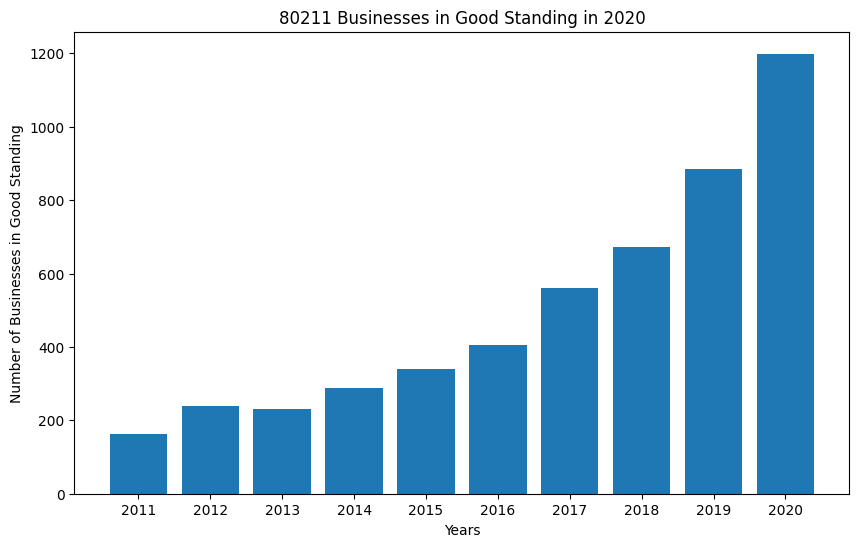

In [26]:
# Create a bar chart of businesses in good standing by year
years = range(2011, 2021)  # years in chart
good = []

# Get number of businesses in good standing each year
for y in years:
    current_year = current[current==y]
    good.append(len(current_year))
    
# Create Bar chart years on x, Number of businesses in good standing on y
plt.bar(years, good, align='center')

# Set x-tick marks label and title
plt.xticks(years)
plt.xlabel('Years')
plt.ylabel('Number of Businesses in Good Standing')
plt.title('80211 Businesses in Good Standing in 2020') # Save figure and show it
plt.savefig('good_standing_by_year.png')
plt.show()

<h3>Step 6: Create a Stacked Bar Chart using Matplotlib</h3>
<ul>
<li>A stacked bar chart is an excellent way to visualize this data because it will allow us to see how the number of businesses being formed each year has changed over time and also the proportion of those businesses that are successful.</li>
<li>To do this we get the counts of successful and unsuccessful business from the data table above and convert them to lists.</li>
<li>The rest of the code is exactly like the stacked bar chart example given in lecture.</li>
<li>Notice how the number of businesses being formed each year is "mostly" increasing.&nbsp; Also the number of businesses in "Good Standing" is highest for more recent years (which would be expected).</li>
</ul>

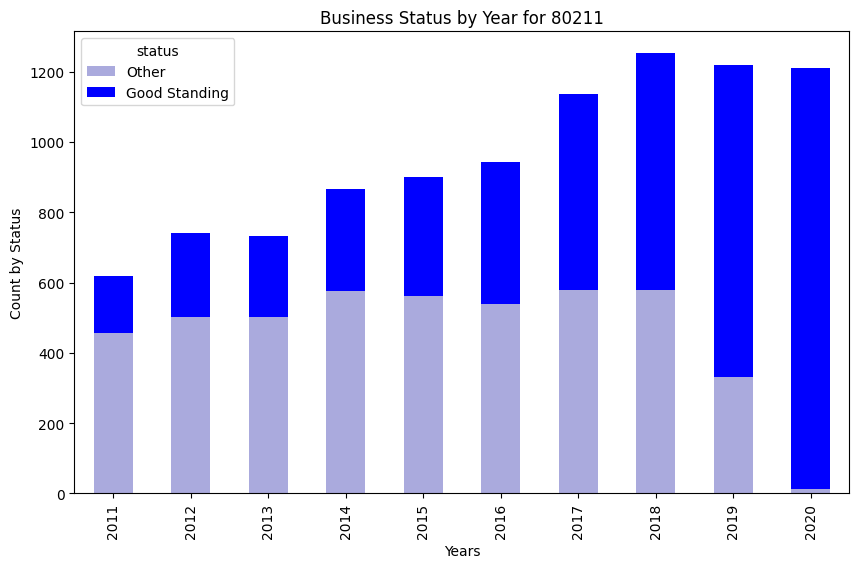

In [32]:
# Create a stacked bar chart with companies in "Good Standing" on the top 
plt.rcParams["figure.figsize"] = (10,6)

table.plot.bar(stacked=True, color=['#aaaadd', "#0000ff"])
# Add text to the chart
plt.xlabel('Years')
plt.ylabel('Count by Status')
plt.title('Business Status by Year for 80211')
plt.show()

<ul><li>Try a Scatter Chart to Visualiza the data.  It does not work so well...</li></ul>

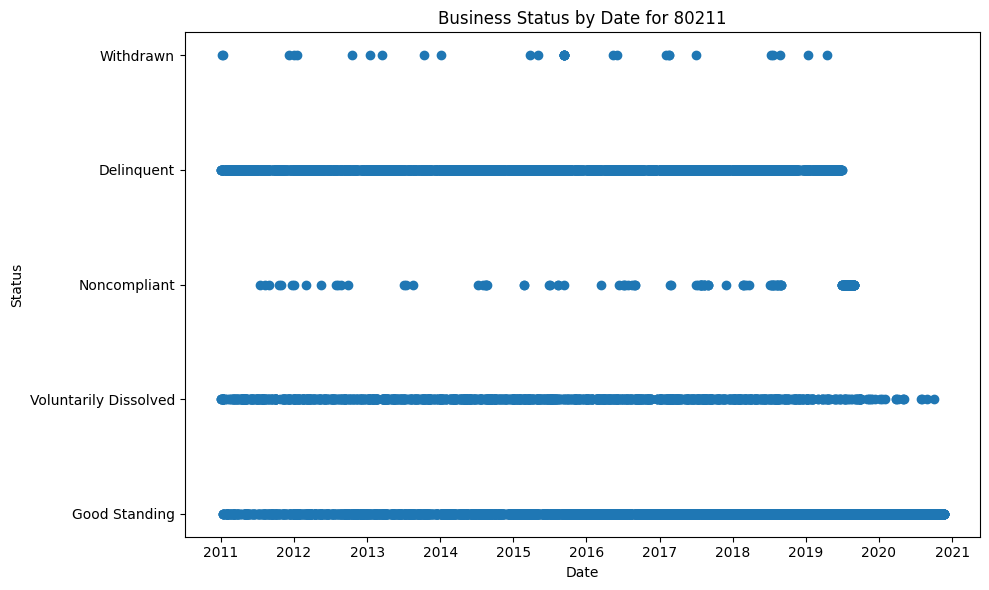

In [28]:
# Scatter chart to plot by date

# Create scatter plot formdate on x, status on y
plt.scatter(formdate, status)

# Set titles and labels
plt.xlabel('Date')
plt.ylabel('Status')
plt.title('Business Status by Date for 80211')

# Use tight_layout otherwise y labels cut off  
plt.tight_layout()

# Save the figure and show the chart 
plt.savefig('status_by_date.png') 
plt.show()


<h3>Step 7: Create a multi-column chart using a Pandas pivot table</h3>
<ul>
<li>You can also use charting features built into Pandas to plot data frame data directly.</li>
<li>We create a Dataframe and&nbsp; pivot table with all of the statuses (not just Good Standing&amp; other)</li>
<li>We use the pivot tale to create a Pandas bar chart showing number of businesses with each type of status by year the business was started.</li>
<li>In this example, I added an extra column "num" that contains all ones just to demonstrate using the np.sum aggregation function in the pivot table.</li>
</ul>


Pivot Table Summing Businesses by Status & Year
               num                                                           
status Delinquent Good Standing Noncompliant Voluntarily Dissolved Withdrawn
year                                                                        
2011        296.0         162.0          6.0                 151.0       3.0
2012        344.0         238.0          7.0                 148.0       3.0
2013        338.0         232.0          3.0                 158.0       3.0
2014        388.0         289.0          6.0                 182.0       1.0
2015        374.0         340.0          7.0                 171.0       9.0
2016        356.0         404.0         10.0                 171.0       2.0
2017        369.0         560.0         18.0                 187.0       4.0
2018        395.0         672.0         22.0                 160.0       3.0
2019        169.0         886.0         84.0                  77.0       2.0
2020          NaN        1

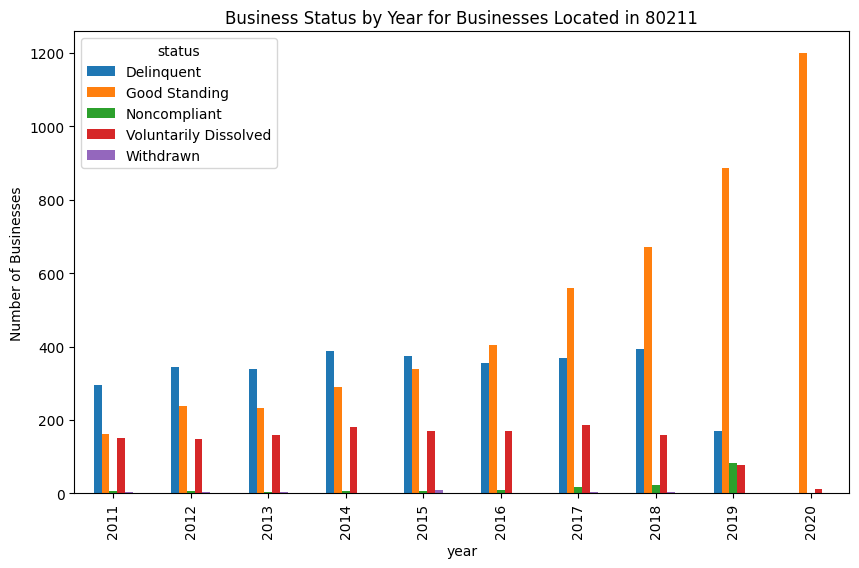

In [29]:
# Using Pandas to create a Multi bar chart from a DataFrame
# Use all of the statuses not just two categories
# Final column is set to all Ones so we can sum the data in a pivot table
data = {"year": yr, "status": status, "num": np.ones(np.size(yr))}
x = pd.DataFrame(data)

table = pd.pivot_table(x, values=['num'], columns=['status'], index=['year'], aggfunc=np.sum)
print("\nPivot Table Summing Businesses by Status & Year\n",table)

# Use Pandas to create the chart
table["num"].plot(kind='bar')
plt.ylabel('Number of Businesses')
plt.title('Business Status by Year for Businesses Located in 80211')
plt.savefig('cobiz_plt2.png')
plt.show()